In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

BATCH_SIZE  = 32
IMAGE_SIZE = 512
CHANNELS = 3
EPOCHS = 50

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Soya",
    shuffle =True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 580 files belonging to 3 classes.


In [6]:
class_name = dataset.class_names
class_name

['100% Good Seeds', '50% Good Seeds', '75% Good Seeds']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 512, 512, 3)
[2 1 2 1 1 1 2 2 1 1 0 1 2 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 2 1 0]


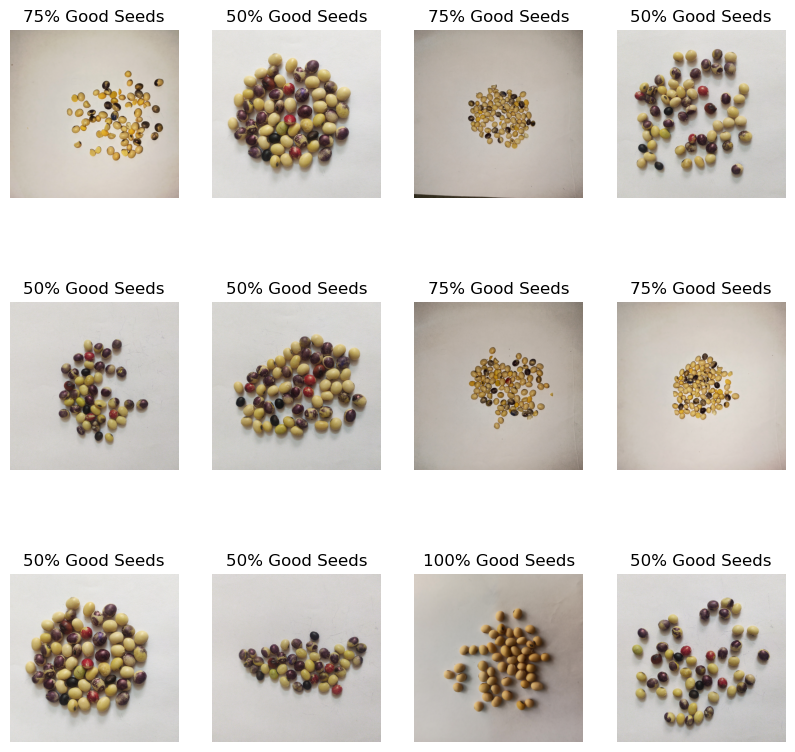

In [8]:
plt.figure(figsize=(10,10))
for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_name[labels_batch[i]])

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split+test_split+val_split) == 1
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return(train_ds, val_ds, test_ds)

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

15

In [12]:
len(val_ds)

1

In [13]:
len(test_ds)

3

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)

])

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)

])

In [17]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 255, 255, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 126, 126, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 62, 62, 64)       

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    #steps_per_epoch=47,
    batch_size=32,
    validation_data=val_ds,
    #validation_steps=6,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
15/15 [==============================] - 29s 2s/step - loss: 0.1288 - accuracy: 0.9667 - val_loss: 0.0360 - val_accuracy: 0.9688
Epoch 2/50
15/15 [==============================] - 32s 2s/step - loss: 0.0710 - accuracy: 0.9896 - val_loss: 0.0799 - val_accuracy: 0.9688
Epoch 3/50
15/15 [==============================] - 28s 2s/step - loss: 0.0357 - accuracy: 0.9917 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 4/50
15/15 [==============================] - 30s 2s/step - loss: 0.0499 - accuracy: 0.9896 - val_loss: 0.1218 - val_accuracy: 0.9062
Epoch 5/50
15/15 [==============================] - 32s 2s/step - loss: 0.0583 - accuracy: 0.9875 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 6/50
15/15 [==============================] - 28s 2s/step - loss: 0.0329 - accuracy: 0.9917 - val_loss: 0.0351 - val_accuracy: 1.0000
Epoch 7/50
15/15 [==============================] - 32s 2s/step - loss: 0.0204 - accuracy: 0.9937 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 8/50
15/15 [==

In [22]:
score = model.evaluate(test_ds)

3/3 [==============================] - 5s 1s/step - loss: 1.8352e-05 - accuracy: 1.0000


In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

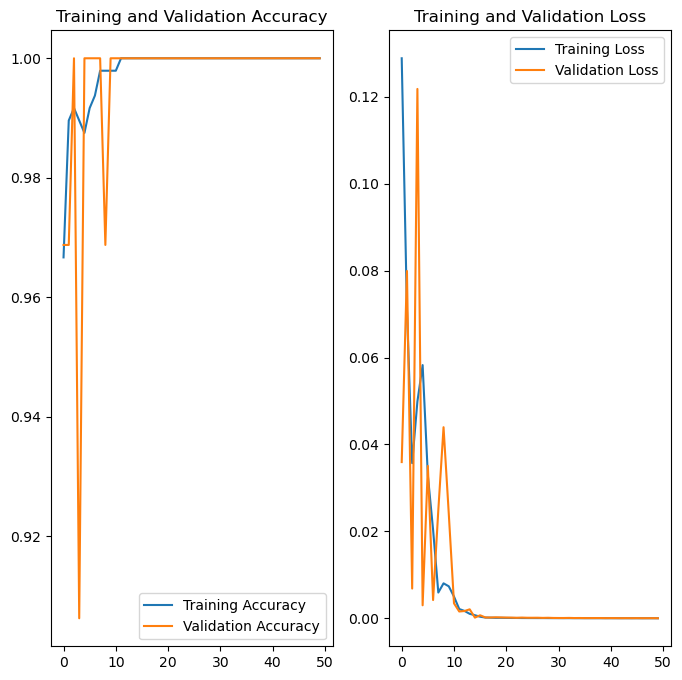

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

actual label: 100% Good Seeds
1/1 [==============================] - 1s 1s/step
predicted label: 100% Good Seeds


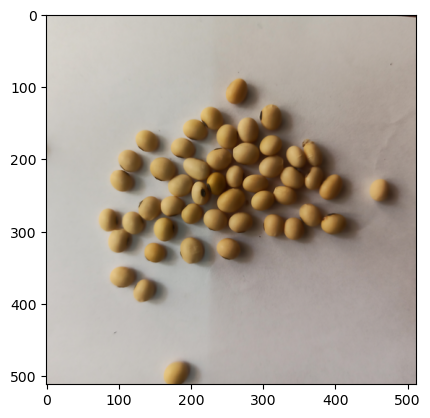

In [36]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    #print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 80ms/step


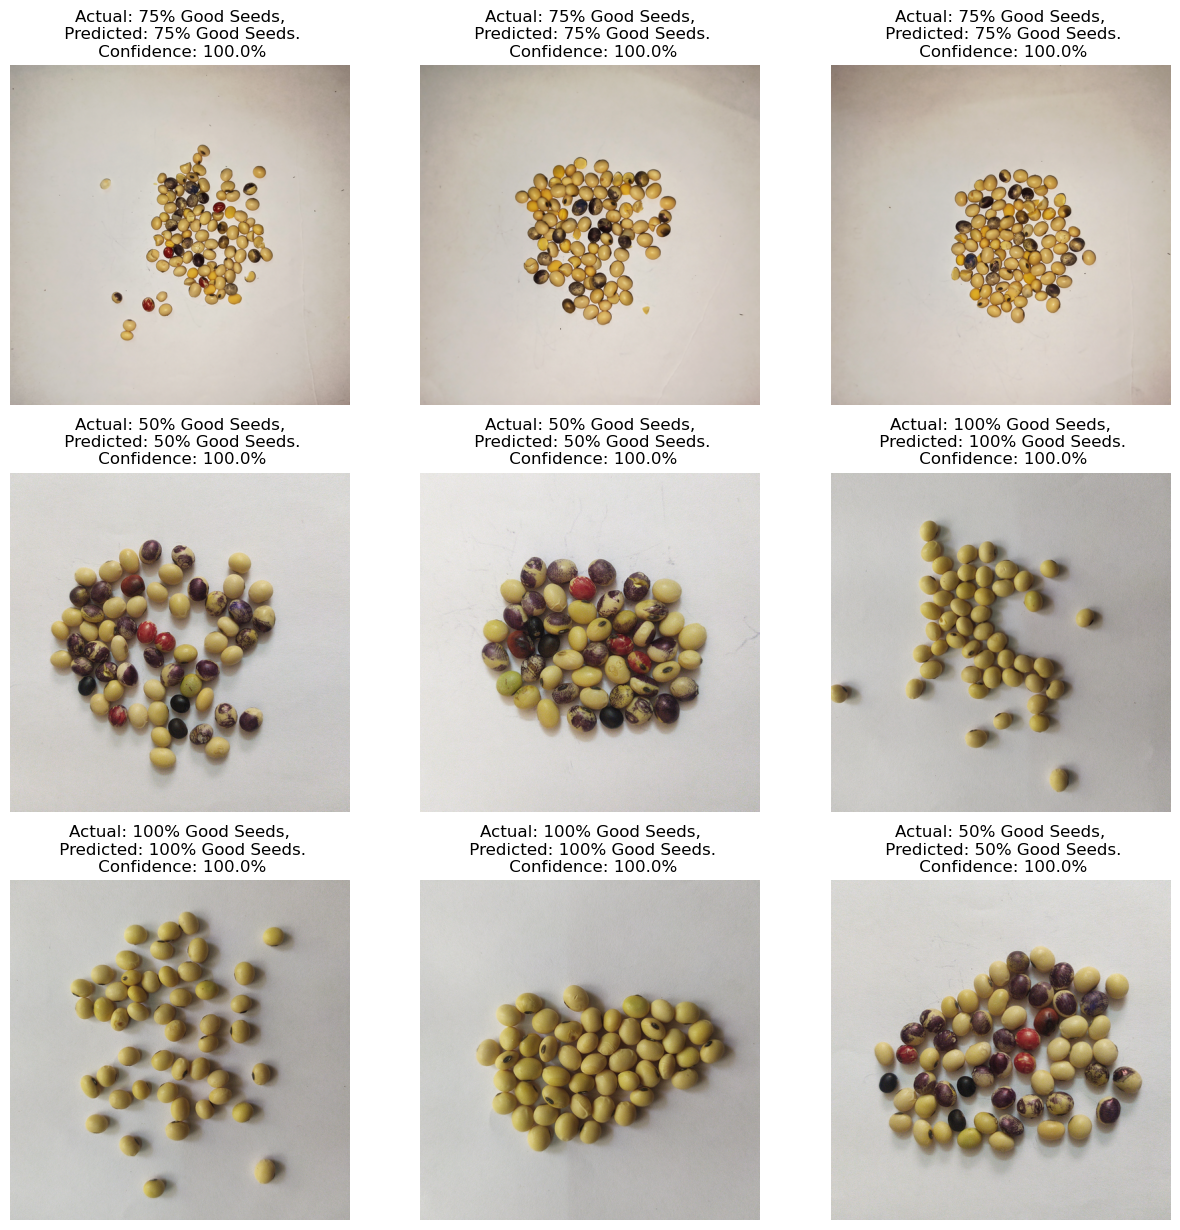

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [44]:
import os
model_version=max([int(i) for i in (os.listdir(" models/") + [0])])+1
model.save(f" models/{model_version}")

FileNotFoundError: [Errno 2] No such file or directory: ' models/'

In [45]:
model_version = 2
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2/assets


INFO:tensorflow:Assets written to: ../models/2/assets
